# Deep Learning Coursework - Jupyter Notebook

## Philip Joseph - 2856883J

## Import the necessary Packages    

In [1]:
# Importing the necessary package
!pip3 install ax-platform --quiet

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydata-profiling 4.6.4 requires numpy<1.26,>=1.16.0, but you have numpy 1.26.4 which is incompatible.
ydata-profiling 4.6.4 requires typeguard<5,>=4.1.2, but you have typeguard 2.13.3 which is incompatible.


In [2]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets 
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
# import sklearn
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
from torch.nn.functional import pad
from torch.utils.data import random_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from ax import optimize
from ax.service.ax_client import AxClient, ObjectiveProperties
from typing import Dict

[WARNING 03-17 11:12:19] ax.service.utils.with_db_settings_base: Ax currently requires a sqlalchemy version below 2.0. This will be addressed in a future release. Disabling SQL storage in Ax for now, if you would like to use SQL storage please install Ax with mysql extras via `pip install ax-platform[mysql]`.


## Creating a Class to process data

In [3]:
class ProteinStructureDataset(Dataset):
    """
    A custom PyTorch dataset for protein structure prediction.

    Args:
        seqs_file (str): The file path to the sequences file.
        labels_file (str, optional): The file path to the labels file. Default is None.
        pssm_dir (str, optional): The directory path to the PSSM files. Default is None.
        mode (str, optional): The mode of the dataset. Default is 'train'.

    Attributes:
        seqs_df (DataFrame): The DataFrame containing the sequences data.
        mode (str): The mode of the dataset.
        amino_acid_mapping (dict): A dictionary mapping amino acids to their corresponding indices.
        label_mapping (dict): A dictionary mapping secondary structure labels to their corresponding indices.
        max_len (int): The maximum length of the sequences in the dataset.
        labels_dict (dict): A dictionary mapping PDB IDs to their corresponding secondary structure labels.
        pssm_dir (str): The directory path to the PSSM files.
        pssm_data (dict): A dictionary mapping PDB IDs to their corresponding PSSM data.

    Methods:
        __len__(): Returns the length of the dataset.
        __getitem__(idx): Returns the item at the given index in the dataset.
        _create_amino_acid_mapping(): Creates a mapping of amino acids to their corresponding indices.
        _load_pssm_data(): Loads the PSSM data from the files.

    """

    def __init__(self, seqs_file, labels_file=None, pssm_dir=None, mode='train'):
        """
        Initializes the ProteinStructureDataset.

        Args:
            seqs_file (str): The file path to the sequences file.
            labels_file (str, optional): The file path to the labels file. Default is None.
            pssm_dir (str, optional): The directory path to the PSSM files. Default is None.
            mode (str, optional): The mode of the dataset. Default is 'train'.
        """
        self.seqs_df = pd.read_csv(seqs_file)
        self.mode = mode
        self.amino_acid_mapping = self._create_amino_acid_mapping()
        self.label_mapping = {'H': 0, 'E': 1, 'C': 2}
        self.max_len = self.seqs_df['SEQUENCE'].str.len().max()
        
        if labels_file is not None and mode == 'train':
            labels_df = pd.read_csv(labels_file)
            self.labels_dict = labels_df.set_index('PDB_ID')['SEC_STRUCT'].to_dict()
        else:
            self.labels_dict = None

        self.pssm_dir = pssm_dir
        self.pssm_data = self._load_pssm_data()

    def __len__(self):
        """
        Returns the length of the dataset.

        Returns:
            int: The length of the dataset.
        """
        return len(self.seqs_df)

    def __getitem__(self, idx):
        """
        Returns the item at the given index in the dataset.

        Args:
            idx (int): The index of the item to retrieve.

        Returns:
            tuple: A tuple containing the encoded sequence, PSSM data, and label (if available).
        """
        pdb_id = self.seqs_df.iloc[idx, 0]
        sequence = self.seqs_df.iloc[idx, 1]
        
        sequence_encoded = [self.amino_acid_mapping.get(aa, self.amino_acid_mapping['PAD']) for aa in sequence]
        sequence_encoded = torch.tensor(sequence_encoded, dtype=torch.long)
        sequence_encoded = pad(sequence_encoded, (0, self.max_len - len(sequence)), value=self.amino_acid_mapping['PAD'])

        label_encoded = None
        if self.mode == 'train' and self.labels_dict is not None:
            label = self.labels_dict.get(pdb_id, "")
            label_encoded = torch.tensor([self.label_mapping[s] for s in label], dtype=torch.long)
            label_encoded = pad(label_encoded, (0, self.max_len - len(label)), value=3)

        pssm_encoded = None
        if self.pssm_dir is not None:
            pssm_encoded = self.pssm_data.get(pdb_id, None)
            if pssm_encoded is None:
                pssm_encoded = torch.full((self.max_len, 20), -2, dtype=torch.float)  # Assuming 20 features for PSSM

        if self.mode == 'train':
            return sequence_encoded, pssm_encoded, label_encoded
        else:
            return sequence_encoded, pssm_encoded

    def _create_amino_acid_mapping(self):
        """
        Creates a mapping of amino acids to their corresponding indices.

        Returns:
            dict: A dictionary mapping amino acids to their corresponding indices.
        """
        amino_acids = 'ACDEFGHIKLMNPQRSTVWY'
        mapping = {aa: i for i, aa in enumerate(amino_acids, start=1)}
        mapping['PAD'] = 0
        return mapping

    def _load_pssm_data(self):
        """
        Loads the PSSM data from the files.

        Returns:
            dict: A dictionary mapping PDB IDs to their corresponding PSSM data.
        """
        pssm_data = {}
        if self.pssm_dir is not None:
            for pdb_id in self.seqs_df['PDB_ID']:
                pssm_file = os.path.join(self.pssm_dir, f'{pdb_id}_{self.mode}.csv')
                if os.path.exists(pssm_file):
                    pssm_df = pd.read_csv(pssm_file)
                    pssm_encoded = torch.tensor(pssm_df.drop(['RES_NUM', 'AMINO_ACID'], axis=1).values, dtype=torch.float)
                    pad_len = self.max_len - pssm_encoded.size(0)
                    pad_tensor = torch.full((pad_len, pssm_encoded.size(1)), -2, dtype=pssm_encoded.dtype)
                    pssm_encoded = torch.cat((pssm_encoded, pad_tensor), dim=0)
                    pssm_data[pdb_id] = pssm_encoded
                else:
                    pssm_data[pdb_id] = None
        return pssm_data


## Defining the CNN model

In [4]:

class FullyConvolutionalNetwork(nn.Module):
    """
    A fully convolutional network for classification tasks.
    
    Args:
        num_features (int): Number of features per residue in the input.
        num_classes (int): Number of classes for output.
        kernel_size (int): Size of the convolutional kernel.
        num_filters (list): List of integers representing the number of filters for each convolutional layer.
        dropout_rate (float): Dropout rate for the dropout layers.
    """
    def __init__(self, num_features, num_classes, kernel_size, num_filters, dropout_rate):
        super(FullyConvolutionalNetwork, self).__init__()
        
        self.model = nn.Sequential(
            nn.Conv1d(in_channels=num_features, out_channels=num_filters[0], kernel_size=kernel_size, padding=kernel_size//2),
            nn.BatchNorm1d(num_filters[0]),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            
            nn.Conv1d(in_channels=num_filters[0], out_channels=num_filters[1], kernel_size=kernel_size, padding=kernel_size//2),
            nn.BatchNorm1d(num_filters[1]),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            
            nn.Conv1d(in_channels=num_filters[1], out_channels=num_filters[2], kernel_size=kernel_size, padding=kernel_size//2),
            nn.BatchNorm1d(num_filters[2]),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            
            nn.Conv1d(in_channels=num_filters[2], out_channels=num_classes, kernel_size=kernel_size, padding=kernel_size//2)
        )
        
    def forward(self, x):
        """
        Forward pass of the fully convolutional network.
        
        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, sequence_length, num_features).
        
        Returns:
            torch.Tensor: Output tensor of shape (batch_size, sequence_length, num_classes).
        """
        x = self.model(x.permute(0, 2, 1))
        return x.permute(0, 2, 1)


# initiation of the model parameters
num_features = 20  # Number of features per residue in the input, adjust based on your PSSM profile size
num_classes = 4  # Number of classes for output (H, E, C) and padding


## Hyper Parameter Tuning

### Define the Tuning Functions and Parameters

In [5]:
#padding is denoted by 3, we ignore it to calculate the loss
ignore_padding=3

In [6]:
def train_evaluate(parameterization: Dict, num_epochs=20, num_classes=4):  # Adjust num_classes for padding
    # Determine device to use (CPU or GPU)
    device = "cuda" if torch.cuda.is_available() else "cpu"
  
    # Setup your dataset and dataloaders
    train_dataset = ProteinStructureDataset(seqs_file='/kaggle/input/deep-learning-for-msc-202324/seqs_train.csv',
                                            labels_file='/kaggle/input/deep-learning-for-msc-202324/labels_train.csv',
                                            pssm_dir='/kaggle/input/deep-learning-for-msc-202324/train',
                                            mode='train')
    test_abs = int(len(train_dataset) * 0.8)
    train_subset, val_subset = random_split(train_dataset, [test_abs, len(train_dataset) - test_abs])
    
    # Create DataLoader objects for training and validation subsets
    train_loader = DataLoader(train_subset, batch_size=int(parameterization.get("batch_size", 32)), shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=int(parameterization.get("batch_size", 32)), shuffle=False)
    
    # Initialize the model with given parameters
    model = FullyConvolutionalNetwork(num_features=21, 
                                   num_classes=4,  # Assuming one extra class for padding
                                   kernel_size=parameterization.get("kernel_size", 5),
                                   num_filters=[parameterization.get(f"num_filters_layer{i}", 64) for i in range(1, 4)],
                                   dropout_rate=parameterization.get("dropout_rate", 0.5)).to(device)

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss() 
    optimizer = optim.Adam(model.parameters(), lr=parameterization.get("lr", 0.001))
    
    # Iterate over each epoch
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        # Iterate over training batches
        for sequences, pssms, labels in train_loader:
            sequences, pssms, labels = sequences.to(device), pssms.to(device), labels.to(device)
            inputs = torch.cat((sequences.unsqueeze(-1), pssms), dim=2)  # Concatenate sequence and PSSM tensors
            optimizer.zero_grad()  # Zero the gradients
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs.reshape(-1, num_classes), labels.reshape(-1))  # Calculate loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update model parameters
        
        model.eval()  # Set model to evaluation mode
        val_loss = 0.0
        correct_predictions = 0
        total_predictions = 0
        # Disable gradient calculation
        with torch.no_grad():
            # Iterate over validation batches
            for sequences, pssms, labels in val_loader:
                sequences, pssms, labels = sequences.to(device), pssms.to(device), labels.to(device)
                inputs = torch.cat((sequences.unsqueeze(-1), pssms), dim=2)
                outputs = model(inputs)
                
                outputs_flat = outputs.reshape(-1, outputs.shape[-1])  # Flatten output for loss calculation
                labels_flat = labels.reshape(-1)
                non_padded_indices = labels_flat != ignore_padding  # Assuming ignore_padding is defined somewhere
                outputs_flat = outputs_flat[non_padded_indices]
                labels_flat = labels_flat[non_padded_indices]
                
                val_loss += criterion(outputs_flat, labels_flat).item()  # Calculate validation loss
                _, predicted_labels = torch.max(outputs_flat, 1)  # Get predicted labels
                correct_predictions += (predicted_labels == labels_flat).sum().item()  # Count correct predictions
                total_predictions += labels_flat.size(0)  # Count total predictions

        val_loss /= len(val_loader)  # Average validation loss
        val_accuracy = 100 * (correct_predictions / total_predictions)  # Calculate validation accuracy

        return {"val_loss": (val_loss, 0.0)}  # Return validation loss


In [7]:
# Function to optimize hyperparameters
def optimize_hyperparameters():
    ax_client = AxClient()
    
    # Create experiment in AxClient
    ax_client.create_experiment(
        name="protein_experiment",
        parameters=[
            {"name": "lr", "type": "range", "bounds": [1e-5, 1e-1], "log_scale": True},  # Learning rate range with logarithmic scale
            {"name": "batch_size", "type": "choice", "values": [16, 32, 64]},  # Batch size choices
            {"name": "kernel_size", "type": "choice", "values": [3, 5, 7]},  # Kernel size choices
            {"name": "num_filters_layer1", "type": "choice", "values": [32, 64, 128]},  # Number of filters for layer 1 choices
            {"name": "num_filters_layer2", "type": "choice", "values": [64, 128, 256]},  # Number of filters for layer 2 choices
            {"name": "num_filters_layer3", "type": "choice", "values": [128, 256, 512]},  # Number of filters for layer 3 choices
            {"name": "dropout_rate", "type": "range", "bounds": [0.0, 0.5]},  # Dropout rate range
        ],
        objectives={"val_loss": ObjectiveProperties(minimize=True)}  # Objective to maximize validation accuracy
    )
    
    for _ in range(25):  # Number of trials
        parameters, trial_index = ax_client.get_next_trial()
        metrics = train_evaluate(parameters)  # Train and evaluate model with given hyperparameters
        ax_client.complete_trial(trial_index=trial_index, raw_data=metrics)  # Complete trial and log metrics
        
    best_parameters, values = ax_client.get_best_parameters()  # Get best parameters and corresponding values
    best_val_accuracy = values[0]["val_loss"]  # Best validation accuracy
    
    # Print best parameters and validation accuracy
    print(f"Best Parameters: {best_parameters}")
    print(f"Best Validation Loss: {best_val_accuracy}")

    return best_parameters

### Run the Hyperparameter Tuning

In [8]:
if __name__ == "__main__":
    best_params = optimize_hyperparameters()
    print(f"Optimization completed. Best parameters: {best_params}")

[INFO 03-17 11:12:19] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 6 decimal points.
[INFO 03-17 11:12:19] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter lr. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 03-17 11:12:19] ax.service.utils.instantiation: Inferred value type of ParameterType.INT for parameter batch_size. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 03-17 11:12:19] ax.service.utils.instantiation: Inferred value type of ParameterType.INT for parameter kernel_size. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 03-17 11:12:19

Best Parameters: {'lr': 0.00013248612752192351, 'batch_size': 16, 'kernel_size': 7, 'num_filters_layer1': 128, 'num_filters_layer2': 256, 'num_filters_layer3': 512, 'dropout_rate': 0.0830763788557902}
Best Validation Loss: 0.7520807629403484
Optimization completed. Best parameters: {'lr': 0.00013248612752192351, 'batch_size': 16, 'kernel_size': 7, 'num_filters_layer1': 128, 'num_filters_layer2': 256, 'num_filters_layer3': 512, 'dropout_rate': 0.0830763788557902}


## Model Implementation

In [17]:
best_params

{'lr': 0.00013248612752192351,
 'batch_size': 16,
 'kernel_size': 7,
 'num_filters_layer1': 128,
 'num_filters_layer2': 256,
 'num_filters_layer3': 512,
 'dropout_rate': 0.0830763788557902}

In [18]:
# Retrieve the best hyperparameters from the optimization
tune_lr = best_params['lr']
tune_batch_size = best_params['batch_size']
tune_kernel_size = best_params['kernel_size']
tune_num_filters_layers=[best_params['num_filters_layer1'],best_params['num_filters_layer2'],best_params['num_filters_layer3']]
tune_dropout_rate = best_params['dropout_rate']

In [19]:
# Import the random module
import random

# Set the seed for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Check if CUDA is available and set the seed for GPU
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)


In [20]:
# Load the train datast
train_dataset = ProteinStructureDataset(seqs_file='/kaggle/input/deep-learning-for-msc-202324/seqs_train.csv',
                                        labels_file='/kaggle/input/deep-learning-for-msc-202324/labels_train.csv',
                                        pssm_dir='/kaggle/input/deep-learning-for-msc-202324/train',
                                        mode='train')

In [21]:
def create_data_loaders(train_dataset, tune_batch_size):
        """
        Create data loaders for training and validation subsets.

        Args:
                train_dataset (torch.utils.data.Dataset): The training dataset.
                tune_batch_size (int): The batch size for the data loaders.

        Returns:
                train_loader (torch.utils.data.DataLoader): The data loader for the training subset.
                val_loader (torch.utils.data.DataLoader): The data loader for the validation subset.
        """
        # Calculate the number of samples for the training subset
        test_abs = int(len(train_dataset) * 0.8)

        # Split the train_dataset into training and validation subsets
        train_subset, val_subset = random_split(train_dataset, [test_abs, len(train_dataset) - test_abs])

        # Create data loaders for the training and validation subsets
        train_loader = DataLoader(train_subset, batch_size=tune_batch_size, shuffle=True, num_workers=8)
        val_loader = DataLoader(val_subset, batch_size=tune_batch_size, shuffle=True, num_workers=8)

        return train_loader, val_loader

train_loader,  val_loader = create_data_loaders(train_dataset, tune_batch_size)

In [22]:
# Check if CUDA is available and set the device accordingly
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")

# Create the model with the specified hyperparameters and move it to the device
model = FullyConvolutionalNetwork(num_features=21, 
                                  num_classes=4,  
                                  kernel_size=tune_kernel_size,
                                  num_filters=tune_num_filters_layers,
                                  dropout_rate=tune_dropout_rate).to(device)

# Print the model
print(model)


GPU is available
FullyConvolutionalNetwork(
  (model): Sequential(
    (0): Conv1d(21, 128, kernel_size=(7,), stride=(1,), padding=(3,))
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.0830763788557902, inplace=False)
    (4): Conv1d(128, 256, kernel_size=(7,), stride=(1,), padding=(3,))
    (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.0830763788557902, inplace=False)
    (8): Conv1d(256, 512, kernel_size=(7,), stride=(1,), padding=(3,))
    (9): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.0830763788557902, inplace=False)
    (12): Conv1d(512, 4, kernel_size=(7,), stride=(1,), padding=(3,))
  )
)


In [23]:
# Define the optimizer with the specified learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=tune_lr)

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Specify the number of training epochs
num_epochs = 20

In [24]:
epoch_list = []
train_accuracy_list = []
train_loss_list = []
val_accuracy_list = []
val_loss_list = []

In [25]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    """
    Trains the model for one epoch.

    Args:
        model (torch.nn.Module): The model to be trained.
        train_loader (torch.utils.data.DataLoader): The data loader for training data.
        criterion: The loss function.
        optimizer: The optimizer for updating model parameters.
        device: The device to be used for training.

    Returns:
        epoch_loss (float): The average loss for the epoch.
        epoch_accuracy (float): The accuracy for the epoch.
    """
    model.train()  # Set the model to training mode
    running_loss = 0.0  # Initialize the running loss
    correct_predictions = 0  # Initialize the number of correct predictions
    total_predictions = 0  # Initialize the total number of predictions

    for sequences, pssms, labels in train_loader:  # Iterate over the training data
        sequences = sequences.to(device)  # Move sequences to the specified device
        pssms = pssms.to(device)  # Move pssms to the specified device
        labels = labels.to(device)  # Move labels to the specified device

        sequences = sequences.unsqueeze(-1)  # Add a dimension to sequences
        inputs = torch.cat((sequences, pssms), dim=2)  # Concatenate sequences and pssms along the last dimension

        # Forward pass
        outputs = model(inputs)  # Perform forward pass
        outputs = outputs.reshape(-1, outputs.shape[-1])  # Reshape outputs
        labels = labels.reshape(-1)  # Reshape labels

        loss = criterion(outputs, labels)  # Calculate the loss
        optimizer.zero_grad()  # Zero the gradients
        loss.backward()  # Backward pass
        optimizer.step()  # Update model parameters

        running_loss += loss.item()  # Accumulate the running loss

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)  # Get the predicted labels
        non_padded_indices = labels != 3  # Get indices of non-padded labels
        correct_predictions += (predicted == labels)[non_padded_indices].sum().item()  # Count correct predictions
        total_predictions += non_padded_indices.sum().item()  # Count total predictions

    epoch_accuracy = 100 * correct_predictions / total_predictions  # Calculate epoch accuracy
    epoch_loss = running_loss / len(train_loader)  # Calculate average epoch loss

    return epoch_loss, epoch_accuracy  # Return average loss and accuracy for the epoch


In [26]:
# Define a function to validate the model for one epoch
def validate_epoch(model, valid_loader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    val_running_loss = 0.0  # Initialize the running loss for validation
    val_correct_predictions = 0  # Initialize the number of correct predictions for validation
    val_total_predictions = 0  # Initialize the total number of predictions for validation

    with torch.no_grad():  # Disable gradient calculation during validation
        for sequences, pssms, labels in valid_loader:  # Iterate over the validation data
            sequences, pssms, labels = sequences.to(device), pssms.to(device), labels.to(device)  # Move data to the specified device
            sequences = sequences.unsqueeze(-1)  # Add a dimension to sequences
            inputs = torch.cat((sequences, pssms), dim=2)  # Concatenate sequences and pssms along the last dimension

            outputs = model(inputs)  # Perform forward pass
            outputs = outputs.reshape(-1, outputs.shape[-1])  # Reshape outputs
            labels = labels.reshape(-1)  # Reshape labels
            loss = criterion(outputs, labels)  # Calculate the loss

            val_running_loss += loss.item()  # Accumulate the running loss for validation

            _, predicted = torch.max(outputs, 1)  # Get the predicted labels
            non_padded_indices = labels != 3  # Get indices of non-padded labels
            val_correct_predictions += (predicted == labels)[non_padded_indices].sum().item()  # Count correct predictions for validation
            val_total_predictions += non_padded_indices.sum().item()  # Count total predictions for validation

    val_epoch_accuracy = 100 * val_correct_predictions / val_total_predictions  # Calculate validation accuracy for the epoch
    val_epoch_loss = val_running_loss / len(valid_loader)  # Calculate average validation loss for the epoch
    val_accuracy_list.append(val_epoch_accuracy)  # Append validation accuracy to the list
    val_loss_list.append(val_epoch_loss)  # Append validation loss to the list

    return val_epoch_loss, val_epoch_accuracy  # Return average validation loss and accuracy for the epoch


In [27]:
# Function to train the model
def train_model(model, train_loader, valid_loader, criterion, optimizer, num_epochs, device):
    global train_accuracy_list, train_loss_list, val_accuracy_list, val_loss_list, epoch_list
    
    # Iterate over the specified number of epochs
    for epoch in range(num_epochs):
        # Train the model for one epoch and get the loss and accuracy
        train_loss, train_accuracy = train_epoch(model, train_loader, criterion, optimizer, device)
        
        # Append the epoch number, train accuracy, and train loss to the respective lists
        epoch_list.append(epoch + 1)
        train_accuracy_list.append(train_accuracy)
        train_loss_list.append(train_loss)
        
        # Print the train loss and accuracy for the current epoch
        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%')

        # Validate the model for one epoch and get the loss and accuracy
        val_loss, val_accuracy = validate_epoch(model, valid_loader, criterion, device)
        
        # Append the validation accuracy and loss to the respective lists
        val_accuracy_list.append(val_accuracy)
        val_loss_list.append(val_loss)
        
        # Print the validation loss and accuracy for the current epoch
        print(f'Epoch [{epoch + 1}/{num_epochs}], Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')

    # Print a message indicating that training is finished
    print('Finished Training')




In [28]:
# train the model
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device)

Epoch [1/20], Train Loss: 0.1461, Train Accuracy: 53.03%
Epoch [1/20], Validation Loss: 0.1094, Validation Accuracy: 61.85%
Epoch [2/20], Train Loss: 0.1044, Train Accuracy: 65.27%
Epoch [2/20], Validation Loss: 0.0912, Validation Accuracy: 70.27%
Epoch [3/20], Train Loss: 0.0973, Train Accuracy: 68.18%
Epoch [3/20], Validation Loss: 0.0904, Validation Accuracy: 70.48%
Epoch [4/20], Train Loss: 0.0919, Train Accuracy: 70.32%
Epoch [4/20], Validation Loss: 0.0846, Validation Accuracy: 72.92%
Epoch [5/20], Train Loss: 0.0892, Train Accuracy: 71.26%
Epoch [5/20], Validation Loss: 0.0832, Validation Accuracy: 73.19%
Epoch [6/20], Train Loss: 0.0878, Train Accuracy: 71.77%
Epoch [6/20], Validation Loss: 0.0816, Validation Accuracy: 73.75%
Epoch [7/20], Train Loss: 0.0856, Train Accuracy: 72.56%
Epoch [7/20], Validation Loss: 0.0794, Validation Accuracy: 74.49%
Epoch [8/20], Train Loss: 0.0834, Train Accuracy: 73.26%
Epoch [8/20], Validation Loss: 0.0793, Validation Accuracy: 74.39%
Epoch [9

## Model Metrics Check

In [29]:
val_accuracy_list = list(set(val_accuracy_list))
val_loss_list = list(set(val_loss_list))

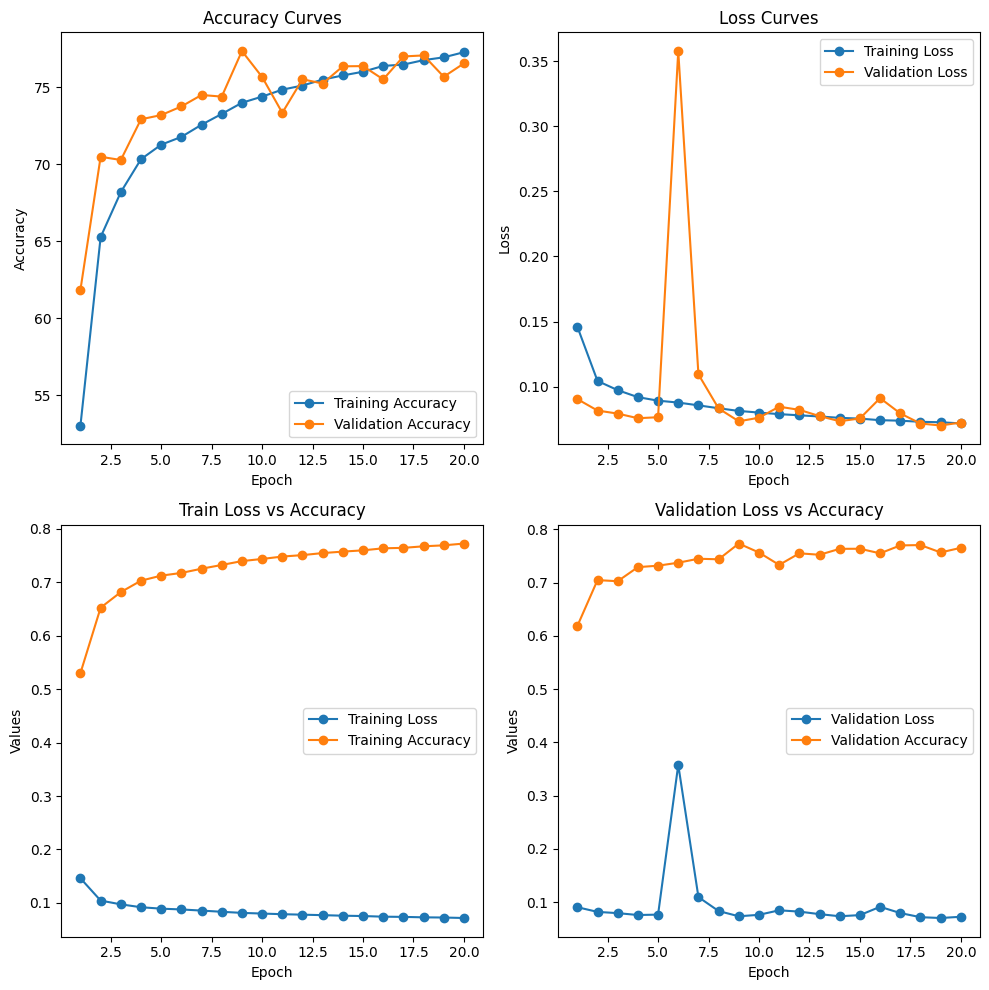

In [30]:
import matplotlib.pyplot as plt


# Plotting accuracy
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.plot(epoch_list, train_accuracy_list, label='Training Accuracy', marker='o')
plt.plot(epoch_list, (val_accuracy_list), label='Validation Accuracy', marker='o')
plt.title('Accuracy Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plotting loss
plt.subplot(2, 2, 2)
plt.plot(epoch_list, train_loss_list, label='Training Loss', marker='o')
plt.plot(epoch_list, (val_loss_list), label='Validation Loss', marker='o')
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(epoch_list, train_loss_list, label='Training Loss', marker='o')
plt.plot(epoch_list, [x / 100 for x in train_accuracy_list], label='Training Accuracy', marker='o')
plt.title('Train Loss vs Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Values')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(epoch_list, val_loss_list, label='Validation Loss', marker='o')
plt.plot(epoch_list, [x / 100 for x in val_accuracy_list], label='Validation Accuracy', marker='o')
plt.title('Validation Loss vs Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Values')
plt.legend()

plt.tight_layout()
plt.show()


The Model looks alright so we are finalising with these metrics.

## Test Implementation

In [31]:
# transform the test dataset
test_dataset = ProteinStructureDataset(seqs_file='/kaggle/input/deep-learning-for-msc-202324/seqs_test.csv',
                                       pssm_dir='/kaggle/input/deep-learning-for-msc-202324/test',
                                       mode='test')
test_loader = DataLoader(test_dataset, batch_size=tune_batch_size, shuffle=False, num_workers=8) # Create the test data loader

In [32]:
# Set the model to evaluation mode
model.eval()

# List to store all predictions
all_predictions = []

with torch.no_grad():
    # Iterate over the test data loader
    for sequences, pssms in test_loader:
        sequences = sequences.to(device)
        pssms = pssms.to(device)
        sequences = sequences.unsqueeze(-1)  # Add channel dimension if necessary
        inputs = torch.cat((sequences, pssms), dim=2)

        outputs = model(inputs)  # Get raw model outputs

        # Convert outputs to probabilities (if your model ends with logits)
        probabilities = torch.softmax(outputs, dim=-1)
        # Get the predicted classes
        _, predicted_classes = torch.max(probabilities, dim=-1)
        all_predictions.extend(predicted_classes.cpu().numpy())

In [33]:
def create_submission_file(predictions, file_names, output_file):
    """
    Create a submission file based on the predictions and file names.

    Parameters:
    predictions (list): A list of arrays containing the predictions.
    file_names (Series): A pandas Series containing the file names.
    output_file (str): The name of the output file.

    Returns:
    None
    """
    # Create data list using list comprehension
    data = [[f"{name}_{j+1}", value] for name, array in zip(file_names, predictions) for j, value in enumerate(array)]

    # Create DataFrame
    df = pd.DataFrame(data, columns=['ID', 'STRUCTURE'])
    df = df[df['STRUCTURE'] != 3]
    df['STRUCTURE'] = df['STRUCTURE'].map({0: 'H', 1: 'E', 2: 'C'})

    df.to_csv(output_file, index=False)

file_names = pd.read_csv('/kaggle/input/deep-learning-for-msc-202324/seqs_test.csv')['PDB_ID']

create_submission_file(all_predictions, file_names, 'submission.csv')